In [6]:
#!pip install demoji

     |████████████████████████████████| 42 kB 1.1 MB/s            


In [8]:
#!pip install textblob

     |████████████████████████████████| 636 kB 1.7 MB/s            
     |████████████████████████████████| 1.5 MB 49.6 MB/s            
     |████████████████████████████████| 763 kB 24.8 MB/s            


In [4]:
#!pip install afinn

     |████████████████████████████████| 52 kB 634 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=b0ac89f62143094224929fca982d52eecbb59730be4719c6c0a33466adac8428
  Stored in directory: /home/jovyan/.cache/pip/wheels/79/91/ee/8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn


In [9]:
#!pip install wordcloud

     |████████████████████████████████| 363 kB 1.8 MB/s            


In [11]:
# !pip install textblob-fr

     |████████████████████████████████| 561 kB 1.5 MB/s            


In [2]:
#!pip install plotly

     |████████████████████████████████| 26.5 MB 9.7 MB/s            


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re
import matplotlib
import plotly.express as px
import seaborn as sns
import datetime
import random
from afinn import Afinn
from datetime import *
import demoji
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
import nltk
from nltk.corpus import stopwords
#from random import random, seed
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Introduction

# Data Wrangling

In [2]:
df_tweets = pd.read_csv("~/work/projetpy/csv_tweets/tweets_vaccins.csv")

Un même tweet peut être posté par le même auteur à des heures différentes. La cellule ci-dessous permet de supprimer ces tweets dupliqués qui ont des valeurs communes de *texte* et *type_vaccin*. Ceratins tweets citent plus d'un vaccin, leurs repétitions selon *texte* et *type_vaccin* est légitime et ne seront pas pris en compte dans la suppression.

In [3]:
df_tweets["datetime"] = df_tweets["date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

df_tweets["date"] = df_tweets["datetime"].apply(datetime.date)

In [4]:
df_tweets.drop_duplicates(subset = ["texte", "type_vaccin"], keep = 'first', inplace=True, ignore_index = True)

In [5]:
df_tweets.head(5)

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07


In [6]:
df_tweets.shape

(6005, 9)

Ainsi, 6005 tweets ont été requétés via l'API sur la période allant du 01 mars 2021 au 26 décembre 2021.

### Nettoyage des données textuelles

Les tweets sont des objets "sales" et cela rend dificile leur manipulation. Pour la suite, il faudra les nettoyer et la foncttion transforme définie à cet effet sert à supprimer les caractères spéciaux, les émojis, les ponctuations, à tranformer les majuscules en minuscule, etc... Les tweets ainsi nettoyés sont contenus dans la variable "texte_propre"

In [7]:
def transforme(texte):
    texte = texte.lower() # mettre les mots en minuscule
    #retirer les liens
    for item in re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+").findall(texte):
        texte=texte.replace(item, "")
    # enlever le retour à la ligne
    texte = texte.replace("\n", " ").replace("\r", "") 
    # supprimer ",", "!", "?", "%", "(",")","/",'"', "$","£", "_", "-", "+", "*", "µ", ":","&,"§" 
    texte = re.sub(r"[,\!\?\%\(\)\/\"\$\£\-\+\*\µ,\:\&\§]", " ", texte) 
    # retirer les hashtags #
    for item in re.compile("([#]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les apostrophes '
    for item in re.compile("([\’])").findall(texte):
        texte=texte.replace(item, " ")
    for item in re.compile("([\'])").findall(texte):
        texte=texte.replace(item, " ")
    # retirer les points de suspension
    for item in re.compile("([.]{1,5})").findall(texte):
        texte=texte.replace(item, "") 
    # retirer les personnes tagées
    for item in re.compile("([@]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les adresses mail
    for item in re.findall('\S+@\S+', texte) :
        texte=texte.replace(item, "")
    # retire les mots contenant des chiffres
    texte = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", texte)
    # retirer les emojis
    for item in demoji.findall(texte):
        texte=texte.replace(item,"")
    return texte

In [8]:
df_tweets["texte_propre"] = df_tweets["texte"].apply(lambda x: transforme(x))
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...


Pour créer les wordclouds, les mots vides du texte doivent être mis à jour spécifiquement pour le domaine du texte.En effet pour des tweets sur les vaccins Covid, certains mots comme *vaccin*, etc... pourraient ne pas avoir d'importance pour l'analyse.

In [9]:
# Pour enlever les stopwords
nltk.download('stopwords')
# nltk.download('punkt')
stop_words = list(stopwords.words('french'))

for x in ['vaccin', 'vaccins', 'vaccination', 'comme', 'alors']:
    stop_words.append(x)
    
# stop_words

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Calcul du sentiment d'un tweet à partir de la polarité de Textblob

In [10]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [11]:
def tweet_polarite(text):
    return tb(text).sentiment[0]

In [12]:
def tweet_label_car(text):
    if tweet_polarite(text) > 0 :
        return "positif"
    if tweet_polarite(text) < 0 :
        return "negatif"
    return "neutre"

In [13]:
def tweet_label(text):
    if tweet_polarite(text) > 0 :
        return 1
    if tweet_polarite(text) < 0 :
        return -1
    return 0

In [14]:
df_tweets["score_polarite"] = df_tweets["texte_propre"].apply(tweet_polarite)
df_tweets["label_car"] = df_tweets["texte_propre"].apply(tweet_label_car)
df_tweets["label"] = df_tweets["texte_propre"].apply(tweet_label)

Comme le montre la sortie ci-dessous, on niveau de la variable "label", on a les modalités -1, 0 et 1. -1 matérialise un sentiment négatif, 0 un sentiment neutre et 1 un sentiment positif comme regroupé dans la variable "label_car".

In [15]:
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,score_polarite,label_car,label
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...,0.00,neutre,0
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,-0.40,negatif,-1
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,0.15,positif,1
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,0.15,positif,1
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,0.15,positif,1


### Création de features

Pour bien mener la modélisation, nous extrayons des tweets certaines variables qui nous semblent être importantes comme par exemple les variables binaires renseignant sur le type de vaccin, le nombre de hashtags, de ponctuation, ...

In [16]:
# Création des 'dummy" variables
dummy_df = pd.get_dummies(df_tweets.type_vaccin, prefix="vaccin", prefix_sep='_', drop_first=False)
df_tweets[dummy_df.columns] = dummy_df

In [17]:
def decompte_hashtags(text):
    exp_match = re.compile("([#]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_hashtags"] = df_tweets["texte"].apply(lambda x : decompte_hashtags(x))

In [18]:
def decompte_tags(text):
    exp_match = re.compile("([@]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_tags"] = df_tweets["texte"].apply(lambda x : decompte_tags(x))

In [19]:
def decompte_exclamation(text):
    exp_match = re.compile("(\w?\s?[!])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_exclamation"] = df_tweets["texte"].apply(lambda x : decompte_exclamation(x))

In [20]:
def decompte_mails(text):
    exp_match = re.compile("(\w+[@]\w+[.]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_mails"] = df_tweets["texte"].apply(lambda x : decompte_mails(x))

In [21]:
def decompte_interrogation(text):
    exp_match = re.compile("(\w?\s?[?])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_interrogation"] = df_tweets["texte"].apply(lambda x : decompte_interrogation(x))

In [22]:
def decompte_mot_maj(text):
    exp_match = re.compile("([A-Z][A-Z]+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_maj"] = df_tweets["texte"].apply(lambda x : decompte_mot_maj(x))

In [23]:
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,...,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...,...,0,0,0,1,1,1,0,0,1,2
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,...,0,0,0,1,0,2,0,0,0,0
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,1,0,0,0,2,0,0,0,1
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,0,1,0,0,2,0,0,0,1
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,0,0,1,0,2,0,0,0,1


In [24]:
print("Ainsi, {:1d} tweets ont pu être requetés et {:1d} variables construites. Le dictionnaire de données est le suivant".format(df_tweets.shape[0], df_tweets.shape[1]))

Ainsi, 6005 tweets ont pu être requetés et 23 variables construites. Le dictionnaire de données est le suivant


Le dictionnaire de données est le suivant
+ date
+ id
+ nbre_like
+ nbre_retweet
+ screenName
+ texte
+ type
+ type_vaccin
+ datetime
+ texte_propre
+ score_polarite
+ label_car
+ label
+ vaccin_astrazeneca
+ vaccin_janssen
+ vaccin_moderna
+ vaccin_pfizer
+ nbre_hashtags
+ nbre_tags
+ nbre_exclamation
+ nbre_mails
+ nbre_interrogation
+ nbre_maj

# Exploratory Data Analysis

### Statistiques descriptives

In [25]:
round(df_tweets.describe(), 3)

,id,nbre_like,nbre_retweet,score_polarite,label,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
count,6.005000e+03,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.0,6005.000,6005.000
mean,1.409209e+18,8.904,2.974,0.071,0.350,0.230,0.026,0.169,0.574,1.051,1.231,0.345,0.0,0.265,1.281
std,3.169649e+16,109.422,34.282,0.194,0.793,0.421,0.161,0.375,0.494,2.256,1.626,0.898,0.0,0.727,1.903
min,1.366185e+18,0.000,0.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
25%,1.380763e+18,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
50%,1.404481e+18,1.000,0.000,0.033,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.0,0.000,1.000
75%,1.430842e+18,2.000,0.000,0.160,1.000,0.000,0.000,0.000,1.000,1.000,2.000,0.000,0.0,0.000,2.000
max,1.475089e+18,6036.000,1879.000,1.000,1.000,1.000,1.000,1.000,1.000,24.000,23.000,12.000,0.0,10.000,28.000


Un apercu de la colonne *nbre_mails*, qui a des valeurs minimale et maximale de 0, montre qu'elle est sans intéret pour la suite.

In [26]:
df_tweets = df_tweets.drop("nbre_mails", axis=1)

In [27]:
df_tweets.groupby("type_vaccin")["id"].count()

type_vaccin
astrazeneca    1384
janssen         159
moderna        1013
pfizer         3449
Name: id, dtype: int64

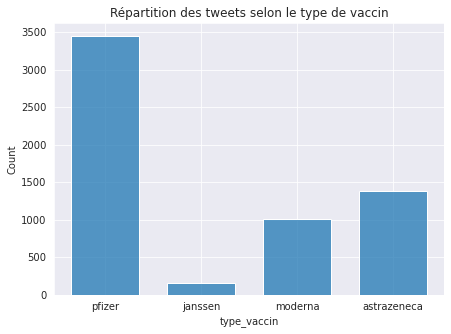

In [28]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="type_vaccin",  shrink=0.7)
plt.title("Répartition des tweets selon le type de vaccin")
plt.show()

Pfizer est le vaccin le plus populaire étant donné qu'environ 3500 tweets l'ont cité. Il est suivi de AstraZeneca avec 1384 mentions et Moderna avec environ 1000 mentions. Janssen est très faiblement représenté avec seulement 159 tweets. 

In [29]:
df_tweets.groupby("label_car")["id"].count()

label_car
negatif    1203
neutre     1495
positif    3307
Name: id, dtype: int64

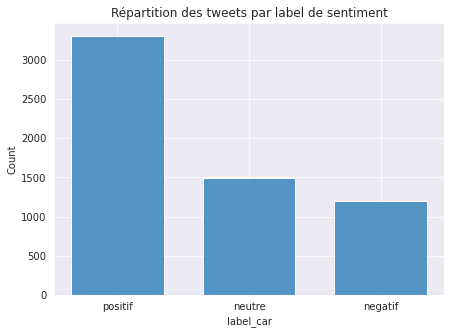

In [30]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
# customPalette = sns.set_palette(sns.diverging_palette(150, 10, n=3))

sns.histplot(df_tweets.sort_values("label_car", ascending=False), x="label_car",  shrink=0.7)# , palette=customPalette)
plt.title("Répartition des tweets par label de sentiment")
plt.show()

Parmi tous les tweets, environ la moitié ont été désignés par TextBlob comme positifs en termes de sentiment (polarité = > 1), l'autre moitié étant constituée de 1203 tweets négatifs (polarité < 0,0) et de 1495 tweets neutres (polarité = 0).

In [31]:
df_tweets.groupby([ "type_vaccin", "label_car"])["id"].count()

type_vaccin  label_car
astrazeneca  negatif       298
             neutre        322
             positif       764
janssen      negatif        34
             neutre         37
             positif        88
moderna      negatif       210
             neutre        249
             positif       554
pfizer       negatif       661
             neutre        887
             positif      1901
Name: id, dtype: int64

<Figure size 720x504 with 0 Axes>

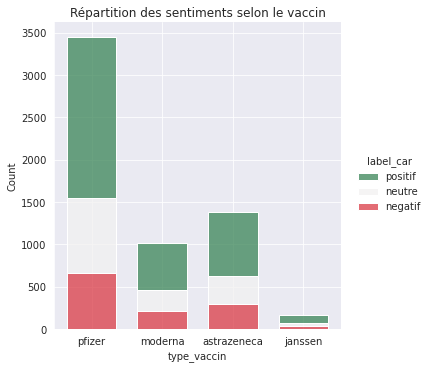

In [32]:
plt.figure(figsize=(10, 7))
# sns.color_palette("Spectral", as_cmap=True)
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(df_tweets.sort_values("label_car", ascending=False), x="type_vaccin", hue="label_car", multiple="stack", shrink=0.7, palette=cpalette)
plt.title("Répartition des sentiments selon le vaccin")
plt.show()

Pour tous les types de vaccins, les tweets "positifs" sont les plus représentés suivi des tweets neutres et enfin des tweets négatifs. La population apprécie en moyenne tous les types de vaccin . 

### Analyse temporelle

Dans cette partie, nous verrons si nous pouvons explorer des tendances par rapport au temps.   
Premièrement, il est utile de visualiser la distribution temporelle de tous les tweets dans l'ensemble de données.

Text(0.5, 1.0, 'Fréquence des tweets par rapport au temps')

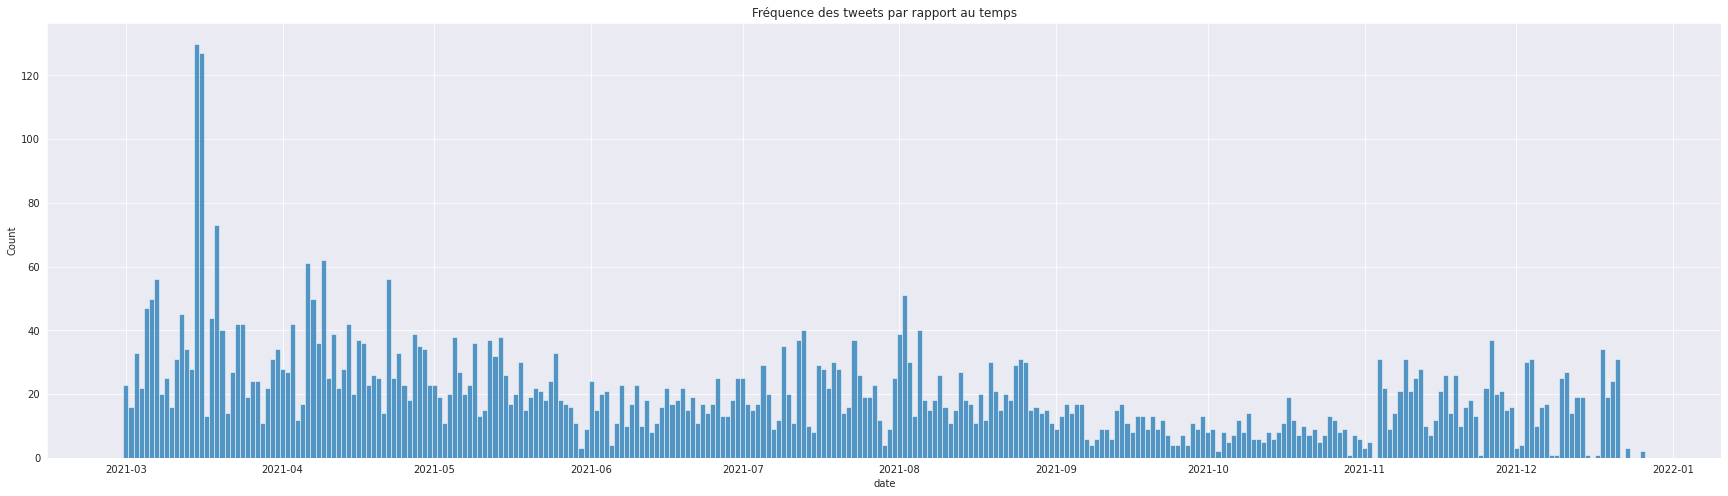

In [33]:
plt.figure(figsize=(30, 8))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="date")
plt.title("Fréquence des tweets par rapport au temps")

In [34]:
df_date = df_tweets.groupby(['date']).agg(np.nanmean).reset_index()
df_date['nbre_tweet'] = df_tweets.groupby(['date']).count().reset_index()['id']
df_date = df_date[['date', 'nbre_tweet', 'score_polarite', 'nbre_like']]
df_date["score_polarite"] = df_date["score_polarite"].astype(float)
# df_date['nbre_tweet']

In [35]:
# plt.figure(figsize=(30, 8))
# plot = plt.scatter(df_date.index, df_date['nbre_tweet'], c=df_date['score_polarite'], cmap='coolwarm')
# plt.clf()
# plt.colorbar(plot)
# ax = sns.barplot(x=df_date.index, y=df_date['nbre_tweet'], hue=df_date['score_polarite'], palette='coolwarm', dodge=False)
# ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins=11))
# ax.set(xlabel="Date",
#       ylabel="nombre_tweets",
#       title="Score de polarité moyen pour les tweets agrégés par date")
# ax.legend_.remove()

### Visualisation avec WordCloud

On se propose ici de visualiser les wordclouds selon le sentiment et selon le vaccin.

In [36]:
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [42]:
def plot_wordcloud_label() :
    # joindre les tweets en une chaine de caractere par type de sentiment
    df_pos = df_tweets[df_tweets['label']==1]
    mots_pos = ' '.join(df_pos['texte_propre'])
    
    df_neg = df_tweets[df_tweets['label']==-1]
    mots_neg = ' '.join(df_neg['texte_propre'])
    
    df_neu = df_tweets[df_tweets['label']==0]
    mots_neu = ' '.join(df_neu['texte_propre'])
    
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    
    wordcloud_neg = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Reds'
                         ).generate(mots_neg)
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Sentiment négatif")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_neu)
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Sentiment neutre")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(stopwords=stop_words,
                          background_color='white', collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_pos)
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Sentiment positif")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();
    # return fig

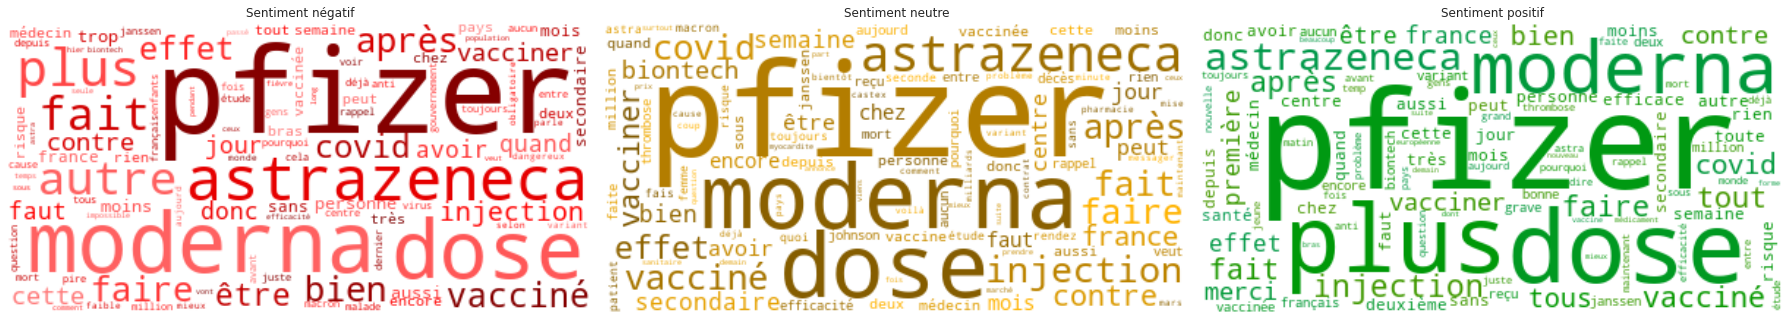

In [43]:
plot_wordcloud_label()

In [44]:
def plot_wordcloud_vaccin(vaccin) :
    vaccin=str(vaccin)
    df_cloud = df_tweets[df_tweets['type_vaccin']==vaccin] 
    # join tweets to a single string
    words = ' '.join(df_cloud['texte_propre'])

    wordcloud = WordCloud(stopwords=stop_words,
                          background_color='white',
                          width=2000, height=1500, max_words=100,
                          collocations=False, collocation_threshold=1, min_word_length=5,
                         ).generate(words)

    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [45]:
def plot_wordcloud_vaccin(vaccin) :
    vaccin=str(vaccin)
    for x in df_tweets["type_vaccin"].unique():
        stop_words.append(x)
    df_cloud = df_tweets[df_tweets['type_vaccin']==vaccin] 
    df_pos = df_cloud[df_cloud['label']==1]
    mots_pos = ' '.join(df_pos['texte_propre'])
    
    df_neg = df_cloud[df_cloud['label']==-1]
    mots_neg = ' '.join(df_neg['texte_propre'])
    
    df_neu = df_cloud[df_cloud['label']==0]
    mots_neu = ' '.join(df_neu['texte_propre'])
    
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    
    wordcloud_neg = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Reds'
                         ).generate(mots_neg)
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Sentiment négatif")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_neu)
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Sentiment neutre")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(stopwords=stop_words,
                          background_color='white', collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_pos)
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Sentiment positif")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

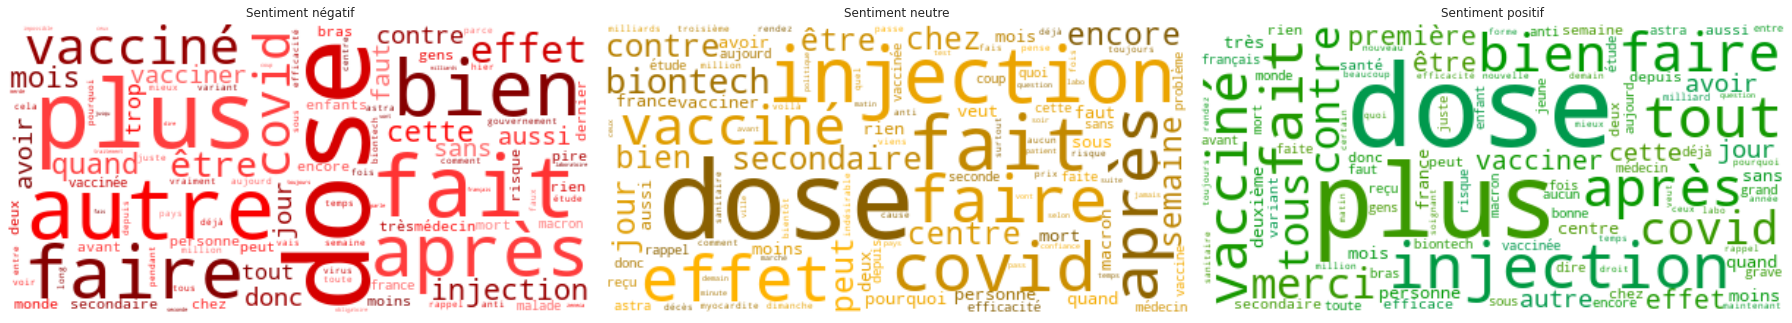

In [46]:
plot_wordcloud_vaccin("pfizer")

# Modelling

Cette section concerne la modélisation où une analyse en composante principale et un modèle d'apprentissage supervisé seront implémentés. 

### Analyse en composante principale ACP

In [47]:
X= df_tweets[[ "vaccin_astrazeneca", "vaccin_janssen", "vaccin_moderna", "vaccin_pfizer", "nbre_hashtags", "nbre_tags", "nbre_exclamation", "nbre_interrogation", "nbre_maj"]]
X # "label",

,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_interrogation,nbre_maj
0,0,0,0,1,1,1,0,1,2
1,0,0,0,1,0,2,0,0,0
2,0,1,0,0,0,2,0,0,1
3,0,0,1,0,0,2,0,0,1
4,0,0,0,1,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...
6000,1,0,0,0,0,1,0,0,2
6001,1,0,0,0,0,1,0,0,2
6002,1,0,0,0,0,1,0,0,0
6003,1,0,0,0,0,2,0,0,0


In [48]:
#instanciation
sc = StandardScaler()

#transformation–centrage-réduction
Z = sc.fit_transform(X)

#instanciation
acp = PCA(svd_solver='full')

#calculs des coordonnées
coord = acp.fit_transform(Z)

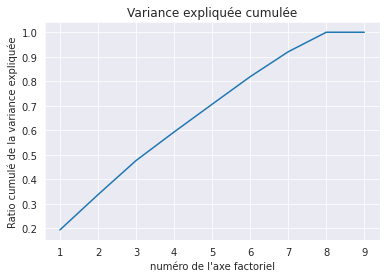

In [49]:
#nombre d'observations
n = X.shape[0]
#nombre de variables
p = X.shape[1]

#variance expliquée (valeur propre)
eigval=acp.explained_variance_

#cumul des variances expliquées
plt.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Variance expliquée cumulée")
plt.ylabel("Ratio cumulé de la variance expliquée")
plt.xlabel("numéro de l'axe factoriel")
plt.show()

Pour avoir 80% de l'information contenue dans les données il faut prendre les 6 premiers axes, ce qui n'est pas très intéressant.

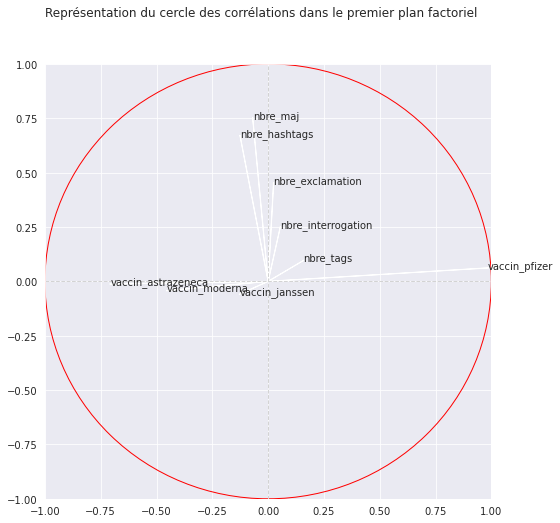

In [50]:
  ### Cercle des corrélations

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * np.sqrt(eigval)[k]
col = ['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5', 'comp_6', 'comp_7', 'comp_8', 'comp_9']
corvar= pd.DataFrame(corvar, index=X.columns, columns = col )
fig, axes=plt.subplots(figsize=(8,8))
fig.suptitle("Représentation du cercle des corrélations dans le premier plan factoriel")
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth=1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth=1)
for j in corvar.index:
    axes.text(corvar['comp_1'][j], corvar['comp_2'][j], j)
    axes.arrow(0,0,corvar['comp_1'][j],corvar['comp_2'][j])
plt.gca().add_artist(plt.Circle((0,0), 1, color = 'red', fill = False))
plt.show()

In [51]:
# verification du scaling
### moyenne
print(np.mean(Z,axis=0))

### ecart-type
print(np.std(Z,axis=0,ddof=0))

[-1.13592178e-16 -1.77487777e-17  6.15290962e-17 -7.57281184e-17
 -6.15290962e-17 -6.15290962e-17  8.28276295e-18  6.15290962e-17
  4.14138147e-18]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [52]:
# instanciation
acp = PCA(svd_solver='full')

In [53]:
# calculs
coord = acp.fit_transform(Z)
# nombre de composantes calculées
print(acp.n_components_) # 6

9


In [54]:
# variance expliquée
print(acp.explained_variance_)

[1.73957819e+00 1.29381201e+00 1.25395341e+00 1.04846306e+00
 1.02023641e+00 1.01221659e+00 9.15758067e-01 7.17481263e-01
 1.33959952e-29]


In [55]:
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[1.73928850e+00 1.29359656e+00 1.25374459e+00 1.04828846e+00
 1.02006651e+00 1.01204803e+00 9.15605568e-01 7.17361782e-01
 1.33937644e-29]


In [ ]:
# scree plot
plt.plot(np.arange(1,p+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

In [ ]:
plt.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

In [ ]:
#seuils pour test des bâtons brisés
bs = 1/np.arange(p,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))

### ***Régression logistique***

#### ***Echantillonnage***

In [81]:
print(df_tweets["label"].value_counts(normalize=True))

 1    0.550708
 0    0.248959
-1    0.200333
Name: label, dtype: float64


In [56]:
print( " Nombre de tweets positifs: ",len (df_tweets[df_tweets["label"]==1]), ", de tweets neutres:",len (df_tweets[df_tweets["label"]==0]), " et de tweets négatifs: ",len (df_tweets[df_tweets["label"]==-1]))

 Nombre de tweets positifs:  3307 , de tweets neutres: 1495  et de tweets négatifs:  1203


Etant donné qu'il y a moins de tweets négatifs (1203 tweets), il faut constituer un dataframe avec 1203 tweets par label pour éviter le biais de surapprentissage causé par une modalité surreprésentée de la variable cible (ici la variable 'label')

In [57]:
# Création d'un dataframe qui équilibre les tweets par label (même nobre de tweets pour chaque label) par tirage aléatoire
df=df_tweets[[ "label","nbre_hashtags", "nbre_tags", "nbre_exclamation", "nbre_interrogation", "nbre_maj"]]

positif=df[
    df['label'].apply(lambda x: x == 1)
]

neutre=df[
    df['label'].apply(lambda x: x == 0)
]
negatif=df[
    df['label'].apply(lambda x: x == -1)
]

seed(430)
A = positif.sample(n=1203, 
               frac=None,
               replace=False,
                weights=None,
                random_state=None,
                axis=None)

B = neutre.sample(n=1203, 
               frac=None,
               replace=False,
                weights=None,
                random_state=None,
                axis=None)
base_model = pd.concat([A,B], ignore_index=True)
base_model = pd.concat([base_model,negatif], ignore_index=True)
len(base_model)

3609

In [58]:
# Partage de l'échantillon en échantillon d'apprentissage et en échantillon test
train, test = train_test_split(base_model,test_size=0.30,random_state=1,stratify=base_model.label)
train.head()

,label,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_interrogation,nbre_maj
1326,0,14,0,0,0,1
1955,0,0,1,1,0,0
3559,-1,1,0,1,1,5
1325,0,0,0,0,0,1
3236,-1,0,1,0,0,0


In [59]:
print("taille échantillon d'apprentissage:", len(train), "échantillon test:", len(test))

taille échantillon d'apprentissage: 2526 échantillon test: 1083


In [60]:
#Division de la base en variable cible et variables indépendantes
ytrain=train.iloc[:,0]
xtrain=train.iloc[:,1:]

ytest=test.iloc[:,0]
xtest=test.iloc[:,1:]

#vérification de la structure
print(xtrain.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2526 entries, 1326 to 732
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   nbre_hashtags       2526 non-null   int64
 1   nbre_tags           2526 non-null   int64
 2   nbre_exclamation    2526 non-null   int64
 3   nbre_interrogation  2526 non-null   int64
 4   nbre_maj            2526 non-null   int64
dtypes: int64(5)
memory usage: 118.4 KB
None


#### ***Model logit multinomial***

In [61]:
#dataframe = df_tweets[["vaccin_astrazeneca", "vaccin_janssen", "vaccin_moderna", "vaccin_pfizer", 'nbre_like', 'nbre_retweet', 'nbre_hashtags', 'nbre_tags', 'nbre_exclamation', 'nbre_interrogation', 'nbre_maj', 'label']]
#X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(['label'], axis=1), df_tweets.label, test_size=0.2, random_state=12344)

In [63]:
model_logit=sm.MNLogit(ytrain,sm.add_constant(xtrain))
resultat=model_logit.fit()
stats1=resultat.summary()
stats2=resultat.summary2()
print(stats1)
#print(stats2)

Optimization terminated successfully.
         Current function value: 1.089551
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                  label   No. Observations:                 2526
Model:                        MNLogit   Df Residuals:                     2514
Method:                           MLE   Df Model:                           10
Date:                Sun, 02 Jan 2022   Pseudo R-squ.:                0.008248
Time:                        21:39:43   Log-Likelihood:                -2752.2
converged:                       True   LL-Null:                       -2775.1
Covariance Type:            nonrobust   LLR p-value:                 1.572e-06
           label=0       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2611      0.076      3.428      0.001       0.112       0.410
nbre_

In [70]:
model_logit1 = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(xtrain, ytrain)
pred=model_logit1.predict(xtest)
conf =pd.DataFrame(confusion_matrix(ytest, pred), index=["Negatif", "Neutre", "Positif"],columns=["predicted_negatif", "predicted_neutre", "predicted_positif"])
conf

,predicted_negatif,predicted_neutre,predicted_positif
Negatif,88,199,74
Neutre,78,240,43
Positif,90,190,81


***Quelques statistiques de robustesse du modèle***

In [77]:
from sklearn.metrics import classification_report
from sklearn import metrics 
#Taux de bon classement
print("Taux de bon classement: %.2f" % (metrics.accuracy_score(ytest, pred)*100),"%, ce qui est très faible") 

Taux de bon classement: 37.77 %, ce qui est très faible


In [78]:
class_report=classification_report(ytest, pred)
print(class_report)


              precision    recall  f1-score   support

          -1       0.34      0.24      0.29       361
           0       0.38      0.66      0.48       361
           1       0.41      0.22      0.29       361

    accuracy                           0.38      1083
   macro avg       0.38      0.38      0.35      1083
weighted avg       0.38      0.38      0.35      1083



#### ***Analyse discriminante***

In [118]:
df=df_tweets[[ "label_car","nbre_hashtags", "nbre_tags", "nbre_exclamation", "nbre_interrogation", "nbre_maj"]]

positif=df[
    df['label_car'].apply(lambda x: x == "positif" )
]

neutre=df[
    df['label_car'].apply(lambda x: x == "neutre")
]
negatif=df[
    df['label_car'].apply(lambda x: x == "negatif")
]

seed(430)
A = positif.sample(n=1203, 
               frac=None,
               replace=False,
                weights=None,
                random_state=None,
                axis=None)

B = neutre.sample(n=1203, 
               frac=None,
               replace=False,
                weights=None,
                random_state=None,
                axis=None)
base_model = pd.concat([A,B], ignore_index=True)
base_model = pd.concat([base_model,negatif], ignore_index=True)
len(base_model)

3609

In [129]:
# Partage de l'échantillon en échantillon d'apprentissage et en échantillon test
train, test = train_test_split(df,test_size=0.30,random_state=1,stratify=df.label_car)
train.head()

,label_car,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_interrogation,nbre_maj
5827,positif,0,2,1,0,1
2626,negatif,0,1,1,0,3
4763,negatif,0,3,0,0,1
786,neutre,0,2,0,0,2
5657,positif,4,2,1,0,4


In [136]:
len(train)

4203

In [130]:
#Division de la base en variable cible et variables indépendantes
ytrain=train.iloc[:,0]
xtrain=train.iloc[:,1:]

ytest=test.iloc[:,0]
xtest=test.iloc[:,1:]

#vérification de la structure
print(xtrain.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4203 entries, 5827 to 5869
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   nbre_hashtags       4203 non-null   int64
 1   nbre_tags           4203 non-null   int64
 2   nbre_exclamation    4203 non-null   int64
 3   nbre_interrogation  4203 non-null   int64
 4   nbre_maj            4203 non-null   int64
dtypes: int64(5)
memory usage: 197.0 KB
None


In [131]:
lda = LinearDiscriminantAnalysis(solver="svd",store_covariance=True)

#apprentissage
lda_train=lda.fit(xtrain,ytrain)

#liste des champs
print("dimensions: ",lda.coef_.shape,'\n')
print("modalités de la variables dépendante: ",)
print(lda.classes_,'\n')
# print(dir(lda))
print("probabilités: ",lda.predict_proba,'\n')

# Coefficients
coeff=pd.DataFrame(lda.coef_.transpose(),columns=lda.classes_,index=xtrain.columns).transpose()
coeff["const"]=lda.intercept_
coeff=coeff.transpose()
coeff

dimensions:  (3, 5) 

modalités de la variables dépendante: 
['negatif' 'neutre' 'positif'] 

probabilités:  <bound method LinearDiscriminantAnalysis.predict_proba of LinearDiscriminantAnalysis(store_covariance=True)> 



,negatif,neutre,positif
nbre_hashtags,0.031105,0.032571,-0.026030
nbre_tags,0.049108,-0.049137,0.004340
nbre_exclamation,0.054960,-0.157424,0.051140
nbre_interrogation,0.027032,-0.076511,0.024738
nbre_maj,-0.028902,-0.054051,0.034934
const,-1.696011,-1.245248,-0.647383


***Analyse de la spécification du modèle: calcul du lambda de Wilks***

In [132]:
# Modification de l'affichage des sorties avec les attributs de numpy: affichage des réels avec 4 décimales
np.set_printoptions(suppress=True,linewidth=120,precision=4)

#Nmobre d'observations en apprentissage
n = train.shape[0]
#nombre de variables
p = train.shape[1]
#nombre de modalités de la variable cible ('label')
k = len(train.value_counts())
# Matrice de covariances
m=n/(n-k)*lda.covariance_
#calcul de son déterminant
detm = np.linalg.det(m)
print("Déterminant de la matrice des covariances : %.4f" % (detm))
#et son logarithme
logdetm = np.log(detm)
print("Logarithme du déterminant : %.4f" % (logdetm))

Déterminant de la matrice des covariances : 80.8770
Logarithme du déterminant : 4.3929


In [133]:
# Calul des covariances totales entre les variables explicatives
T = np.cov(xtrain.values,rowvar=False)

In [141]:
# Calclu du lambda de Wilks
LW = np.linalg.det(lda.covariance_)/np.linalg.det((n-1)/n*T)
print("Le Lambda de Wilks est de :",LW)

Le Lambda de Wilks est de : 0.981223567676579


In [135]:
# Comparaison du Lambda de Wilks à une statistique suivant une loi de Fisher à partir de la transformation de Rao (test de Fisher Rao)

#Lambda de Wilks
print("Lambda de Wilks : %.4f" % (LW))
# degré de liberté du numérateur
ddlnum= p * (k-1)
print("DDL numérateur : %.d" % (ddlnum))
#valeur intermédiaire pour le calcul du ddl dénominateur
tmp = p**2 + (k-1)**2 - 5
tmp = np.where(tmp > 0,np.sqrt(((p**2) * ((k-1)**2) - 4)/tmp),1)
#degré de liberté du dénominateur
ddldenom = (2*n-p-k-2)/2 * tmp - (ddlnum - 2)/2
print("DDL dénominateur : %.d" % (ddldenom))
#stat de test
FRao = LW**(1/tmp)
FRao = ((1-FRao)/FRao)*(ddldenom/ddlnum)
print("Statistique F de Rao : %.4f" % (FRao))
#p-value
print("P-value du test : %.4f" % (1-scipy.stats.f.cdf(FRao,ddlnum,ddldenom)))

Lambda de Wilks : 0.9812
DDL numérateur : 6810
DDL dénominateur : 18381
Statistique F de Rao : 0.0085
P-value du test : 1.0000


On accepte l'hypothèse d'indépendance entre le sentiment (label) et le variables considérées ici comme explicatives, conditionnellement à une égalité des moyennes des tweets entre les différents sentiments. Ce qui traduit que l'analyse discriminante n'est pas le meilleur modèle pour appréhender ce phénomène.